In [106]:
import importlib
from pathlib import Path

# from torch.utils.data import DataLoader, random_split
from torch import cuda, nn, optim, concat
from torch.backends import mps

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans, SpectralClustering, HDBSCAN, MeanShift, estimate_bandwidth

import datasets.mnist_loader as ml
from ptmodels import vae_pytorch as vp
from plotting import ae_plots

# Use a gpu or M1 chipset to train PyTorch networks if you have it.
if cuda.is_available():
    device = 'cuda'

elif mps.is_available():
    device = 'mps'

else: 
    device = 'cpu'

print(f'Using {device}.')

Using mps.


# Project 2: Autoencoders and Variational Autoencoders.
In this project, we are going to first implement a couple autoencoders trained on MNIST-compatible data sets for dimensionality reduction. Afterwards, we'll then create a generative model using a variational autoencoder. 

## Project 2.1: Autoencoders for Dimensionality Reduction.
High dimensionality data frequently has more dimensions than is needed to perform regression, classification, or clustering.  More formally, there is a lot of covariance within most data, covariance that reduces the intrinsic dimensionality of the data set.  Think of image data --- a $128 \times 128$ pixel image can be thought of as a vector $\mathbf{x}$ which resides in a $416384$-dimensional vector space. That does not mean there are $16384$ unique features.  Intuitively, we know there are less features in the data, and those features are captured by correlations between pixels.  In other words, we could find a mapping from the starting representation $\mathbf{x}$ to a reduced-dimension latent representation $\mathbf{z}\in \mathcal{R}^m$, where hopefully $m \ll 16384$.  We can then use more approachable latent representation $\mathbf{z}\in \mathcal{Z}$ to analyze the starting dataset $\mathbf{x}\in \mathcal{X}$.

An autoencoder does this by finding three things: a latent representation $\mathbf{z}\in \mathcal{Z}$, an encoding function $E_{\phi}(\mathbf{x})=\mathbf{z}$ parameterized by $\phi$, and a decoding function $D_{\theta}(\mathbf{z})=\mathbf{x}$ parameterized by $\theta$. Here, we will simultaneously train two dense, multi-layer perceptrons to estimate functions $E_{\phi}$ and $D_{\theta}$, recovering the latent space $\mathcal{Z}$ in the process. 

Training the perceptron networks requires a loss function.  Although the data we are training on is labeled, we will not be using them.  Instead, we are going to perform unsupervised learning.  Specifically, we'll are going to optimize by minimizing the 'distance' between the starting vector $\mathbf{x}$ and its predicted decoding $D_{\phi}(E_{\theta}(\mathbf{x}))$: 

$L(\mathcal{X}|\phi, \theta)=-\frac{1}{N}\sum^N_{i=1}L_2(\mathbf{x}_i, D_{\phi}(E_{\theta}(\mathbf{x}_i)))$

where $N$ is the size of the training data sample $\mathcal{X}$ and $L_2(\mathbf{x}, \mathbf{x}^{\prime})=|| \mathbf{x} - \mathbf{x}^{\prime} ||^2$ is the L2 loss (basically, the Euclidian distance up to some multiplicative constant). To train, we will minimize $L(\mathcal{X}|\phi, \theta)$ with respect to the parameters $\phi$ and $\theta$.

Enough math.  Let's start setting up the model to train!

In [107]:
importlib.reload(ml)
# Let's load some PyTorch DataLoaders we'll be using using a wrapper function in the 'mnist_loader.py' module.
train_dl, validation_dl = ml.load_MNISTlike(
    target_set='MNIST', batch_size_train=64, batch_size_validation=128
)

torch.Size([28, 28])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])


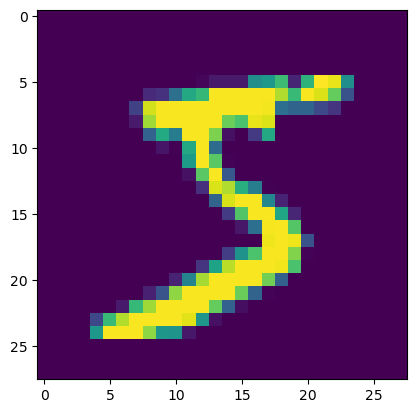

In [108]:
# Let's inspect an image
x, y = train_dl.dataset.__getitem__(0)

print(x[0].shape)  # each image is a single-channel 28 x 28 image.
print(y)  # one-hot encoding correponds to the number 5 label. 
plt.imshow(x.permute(1, 2, 0))
plt.show()

We need a loss function from Pytorch that satisfies the requirements above.  Luckily, `torch.nn.MLELoss` does just that. We'll also use the Adam optimizer.  As for the the model itself, the number of hidden layers will be four, including the final latent layer estimating $\mathcal{Z}$. The starting input dimensionality is $28 \times 28=784$ and we are going to select a latent space dimensionality space of $2$.  The remaining hidden layers will have sizes $112$ and $16$

In [128]:
importlib.reload(vp)

# Model hyperparameters
n_epochs = 5
lr = 7.5e-3
n_latent = 2

# Instantiate model
img_size = (28, 28)
n_layers = [img_size[0] * img_size[1], 196, 49]
n_channels = 1
ae_model = vp.DenseAE(n_layers, n_latent, img_size, n_channels=n_channels)
ae_model = ae_model.to(device)  # apply model to device.

# Select optimizer.
opt = optim.Adam(ae_model.parameters(), lr=lr)

# Select loss fuction.
loss_fn = nn.MSELoss()

# Print parameter count.
sum([x.numel() for x in ae_model.parameters()])

329284

In [129]:
importlib.reload(vp)
# Train model.
validation_loss = vp.train_AE(train_dl, validation_dl, ae_model, opt, loss_fn, n_epochs, device)

Batch [   64/60000] loss: 1.310977.
Batch [12864/60000] loss: 0.864227.
Batch [25664/60000] loss: 0.747374.
Batch [38464/60000] loss: 0.721808.
Batch [51264/60000] loss: 0.739731.
Epoch 1 validation loss: 0.690829.
---------------------------------------
Batch [   64/60000] loss: 0.691515.
Batch [12864/60000] loss: 0.722090.
Batch [25664/60000] loss: 0.665032.
Batch [38464/60000] loss: 0.660621.
Batch [51264/60000] loss: 0.639595.
Epoch 2 validation loss: 0.653650.
---------------------------------------
Batch [   64/60000] loss: 0.675510.
Batch [12864/60000] loss: 0.625250.
Batch [25664/60000] loss: 0.641943.
Batch [38464/60000] loss: 0.607921.
Batch [51264/60000] loss: 0.625350.
Epoch 3 validation loss: 0.644482.
---------------------------------------
Batch [   64/60000] loss: 0.640452.
Batch [12864/60000] loss: 0.625310.
Batch [25664/60000] loss: 0.640268.
Batch [38464/60000] loss: 0.635990.
Batch [51264/60000] loss: 0.645677.
Epoch 4 validation loss: 0.639661.
--------------------

torch.Size([1, 28, 28])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])


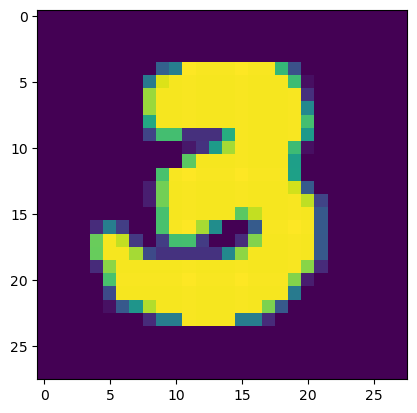

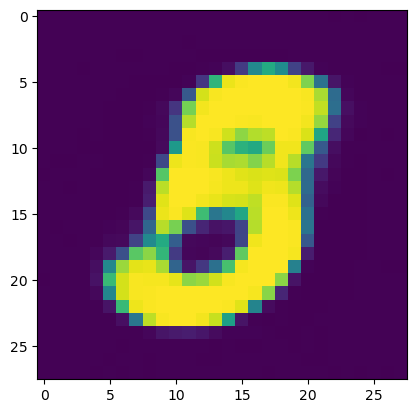

In [124]:
# Alright --- let's see how the model performs.  
# Note that we have to unflatten the prediction, which we do using some torch.nn functionality.
x_test, y_test = validation_dl.dataset.__getitem__(200)
print(x_test.shape)
x_test = x_test.to(device)

# We select the second dimension of the 2D output to unflatten into a 28x28 image.
print(y_test)  # get encoding output. 
plt.imshow(x_test.to('cpu').permute(1, 2, 0))
plt.show()

# Get prediction.
x_pred = ae_model(x_test.unsqueeze(0))

# Note we call the first and in this case, the only, batch member 0 from x_pred.
# This model outputs a batch prediction, hence why we 'unsqueezed our input above.
plt.imshow(x_pred[0].detach().to('cpu').permute(1, 2, 0))
plt.show()


This is a pretty neat result thus far.  Let's consider a couple things real quick.  First, this is only a four-layer encoder that maps to the latent space $\mathcal{Z}$.  We could increase the network depth, or we could even add convolutional layers --- after all, we are trying to encode images.  Second, this encoding exists in two dimensions: $\mathbf{z}\in \mathcal{R}^2$.  This means we were able to start with $768$-dimension vectors and then find a two-dimensional representation that contains enought information about the training data to then recover the initial image with impressive accuracy.  

Let's actually make use of this latent representation and run some clustering algorithms on the validation data set's encoded representations.  Before doing so, we'll collect the encoding predictions first, and the plot the bivariate encoding to see what we are working with.

In [9]:
# Let's loop the validation data set through and get images and labels.
encoding_batches, labels_batches = zip(
    *[(ae_model.get_encoding(xb.to(device)), yb.to(device)) for xb, yb in validation_dl]
)

# Take the tuples of batches and concatenate.  Also, detach the tensors --- no need to track gradients.
encodings = concat(encoding_batches).detach().cpu().numpy()
# normed_encodings = vp.SymmetricLinearAE.normalize_encoding(encodings)
labels = concat(labels_batches).detach().cpu().numpy()


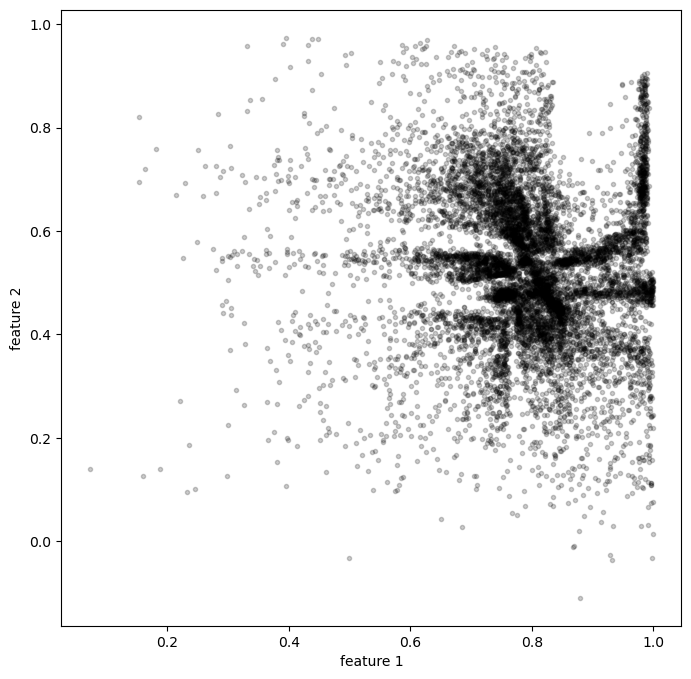

In [10]:
# What does this 2D encoding look like?
encoding_fig = ae_plots.plot_2Dencoding(
    encodings, figsize=(8, 8), marker='.', color='black', alpha=0.2
)
plt.show()

The data exhibits some clearly nonlinear behavior.  Regardless, let's play around with some classification algorithms and see how things look.

In [11]:
# scikit-learn models must first be instantiated, then fit using the 'fit()' method.  
# Keep in mind that the fitting sample must be fed in as a column vector of features. 
# Because we are fitting clustering algorithms, no labels (aka no independent variable values)
# Need to be provided (specifically, the keyword argument 'y=None' for 'fit()').

# Instantiate and fit a K-Means model with 10 clusters.
km_model = KMeans(init='k-means++', n_clusters=10, n_init=8)
km_model.fit(encodings)

# Instantiate and fit a Spectral Clustering model with 10 clusters. This
# algorithm is slower than k-means but does not assume densities are convex
# or isotropic.
# sc_model = SpectralClustering(n_clusters=10, n_init=8)
# sc_model.fit(encodings)

# Instantiate and fit a HDBSCAN model.  This algorithm is more unsupervised,
# finding the label count from the data.
hds_model = HDBSCAN(min_cluster_size=200, min_samples=50)
hds_model.fit(encodings)

# # Instantiate and fit a DBSCAN model.  This algorithm is more unsupervised,
# # finding the label count from the data.
# bw = estimate_bandwidth(encodings, n_samples=500)
# ms_model = MeanShift(bandwidth=bw)
# ms_model.fit(encodings)

HDBSCAN(min_cluster_size=200, min_samples=50)

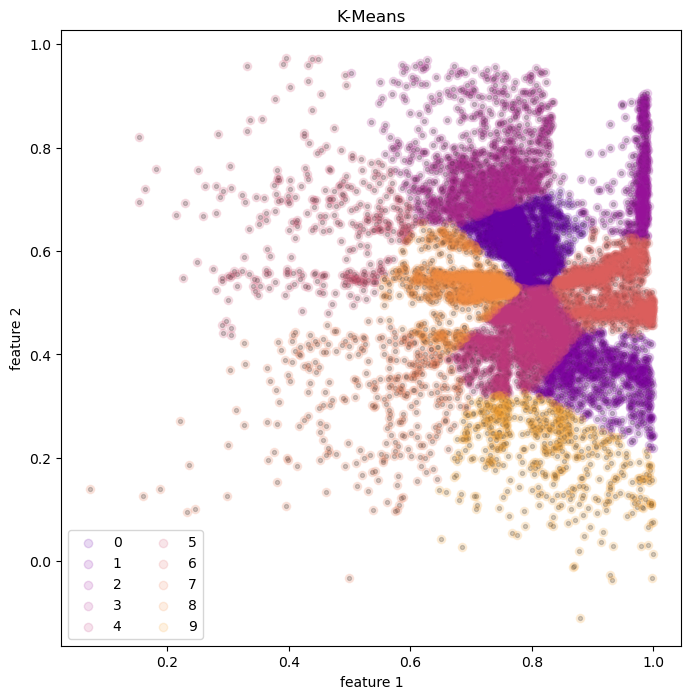

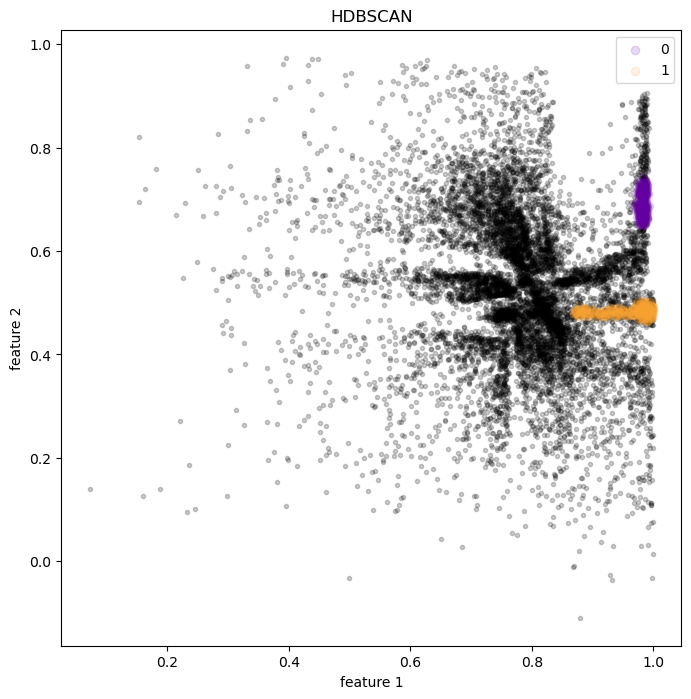

In [12]:
# Let's plot the different clustering algorithm results.
km_fig = ae_plots.plot_2Dencodings_withclusters(
    encodings, km_model.labels_,
    'K-Means', 10,
    encoding_kwargs={'color': 'black', 'marker': '.', 'alpha': 0.2},
    clusters_kwargs={'marker': 'o', 'alpha': 0.15}
)
plt.show()

# sc_fig = ae_plots.plot_2Dencodings_withclusters(
#     encodings, sc_model.labels_,
#     'Spectral Clustering', 10,
#     encoding_kwargs={'color': 'black', 'marker': '.', 'alpha': 0.2},
#     clusters_kwargs={'marker': 'o', 'alpha': 0.15}
# )
# plt.show()

hds_fig = ae_plots.plot_2Dencodings_withclusters(
    encodings, hds_model.labels_,
    'HDBSCAN', hds_model.n_features_in_,
    encoding_kwargs={'color': 'black', 'marker': '.', 'alpha': 0.2},
    clusters_kwargs={'marker': 'o', 'alpha': 0.15}
)
plt.show()

# ms_fig = ae_plots.plot_2Dencodings_withclusters(
#     encodings, ms_model.labels_,
#     'Mean Shift', ms_model.n_features_in_,
#     encoding_kwargs={'color': 'black', 'marker': '.', 'alpha': 0.2},
#     clusters_kwargs={'marker': 'o', 'alpha': 0.15}
# )
# plt.show()

## Project 2.2: ConvNet Autoencoder.

Already we are running into issues discovering clusters in the encoded representation.  The encoded representation is not well-behaved for these clusteringa algorithms, featuring complex density curvature, including varying length scales.  That alone hints that our encoding may be too low a dimension, even if the decoder can still recover a decent prediction from the latent space representation.  It could very well be that only having two latent features is simply insufficient to describe variation in our training set.  

Recall that we are trying to find a latent representation of image data --- maybe it makes sense to instead build an autoencoder with ConvNet layers. Unfortunately, this is easier said then done.  Convolution (technically cross-correlation for ConvNet applications) does have an inverse operation call a transpose convolution.  We could mirror a ConvNet encoder with a transpose ConvNet decoder.  Unfortunately, this ignores using max pooling, a powerful ConvNet layer, especially for deep networks.  By construction, max pooling has no inverse operation since it is a many-to-one operation.  For our ConvNet autoencoder, the encoder will make use of convolutions and max pooling before a single hiddlen linear layer to produce the latent representation, while the decoder will only make use of transpose convolutions after a single hidden linear layer.

In [130]:
importlib.reload(vp)

# Model hyperparameters
n_epochs = 5
channels = [1, 4, 8]
k_layers = [7, 5]
n_latent = 2

# Instantiate model.
n_flat = 7 * 7 * 8  # final hidden convnet 'image' size times number of channels.
conv_ae_model = vp.ConvNetAE(channels, k_layers, n_flat, n_latent).to(device)

# Select optimizer.
lr = 7.5e-3
opt = optim.Adam(conv_ae_model.parameters(), lr=lr)

# Select loss fuction.
loss_fn = nn.MSELoss()

# Get parameter count.
sum([x.numel() for x in conv_ae_model.parameters()])

3149

In [131]:
importlib.reload(vp)
# Train model.
validation_loss = vp.train_AE(train_dl, validation_dl, conv_ae_model, opt, loss_fn, n_epochs, device)

Batch [   64/60000] loss: 1.259685.
Batch [12864/60000] loss: 0.733538.
Batch [25664/60000] loss: 0.682593.
Batch [38464/60000] loss: 0.691357.
Batch [51264/60000] loss: 0.689571.
Epoch 1 validation loss: 0.692699.
---------------------------------------
Batch [   64/60000] loss: 0.692919.
Batch [12864/60000] loss: 0.650358.
Batch [25664/60000] loss: 0.698293.
Batch [38464/60000] loss: 0.754875.
Batch [51264/60000] loss: 0.668902.
Epoch 2 validation loss: 0.688955.
---------------------------------------
Batch [   64/60000] loss: 0.677213.
Batch [12864/60000] loss: 0.735816.
Batch [25664/60000] loss: 0.658699.
Batch [38464/60000] loss: 0.647430.
Batch [51264/60000] loss: 0.684997.
Epoch 3 validation loss: 0.682383.
---------------------------------------
Batch [   64/60000] loss: 0.667218.
Batch [12864/60000] loss: 0.656198.
Batch [25664/60000] loss: 0.741254.
Batch [38464/60000] loss: 0.692965.
Batch [51264/60000] loss: 0.707375.
Epoch 4 validation loss: 0.678584.
--------------------

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])


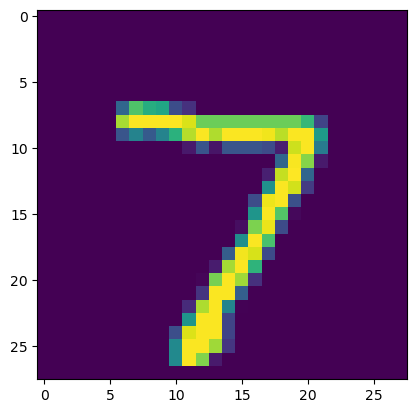

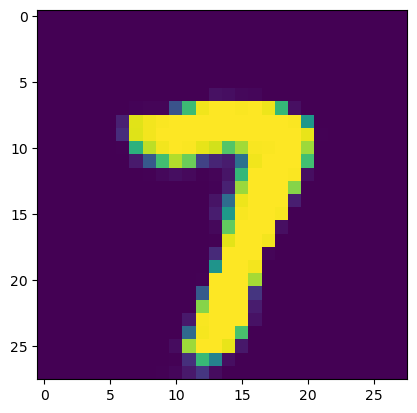

In [133]:
# Alright --- let's see how the ConvNet model performs.  
x_test, y_test = validation_dl.dataset.__getitem__(0)
x_test = x_test.to(device)

# We select the second dimension of the 2D output to unflatten into a 28x28 image.
print(y_test)  # get encoding output. 
plt.imshow(x_test.to('cpu').permute(1, 2, 0))
plt.show()

# Get prediction.
x_pred = conv_ae_model(x_test.unsqueeze(0))

# Note we call the first and in this case, the only, batch member 0 from x_pred.
# This model outputs a batch prediction, hence why we 'unsqueezed our input above.
plt.imshow(x_pred[0].detach().to('cpu').permute(1, 2, 0))
plt.show()
